# ✍ В этом модуле вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель. Как? Узнаем дальше.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
RANDOM_SEED = 42

In [3]:

from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

# Первоначальная версия датасета содержит 17 полей со следующей информацией:

## hotel_address — адрес отеля;
## review_date — дата, когда рецензент разместил соответствующий отзыв;
## average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
## hotel_name — название отеля;
## reviewer_nationality — страна рецензента;
## negative_review— отрицательный отзыв, который рецензент дал отелю;
## review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
## positive_review — положительный отзыв, который рецензент дал отелю;
## review_total_positive_word_counts — общее количество слов в положительном отзыве.
## reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
## total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
## total_number_of_reviews — общее количество действительных отзывов об отеле;
## tags — теги, которые рецензент дал отелю;
## days_since_review — количество дней между датой проверки и датой очистки;
## additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
## lat — географическая широта отеля;
## lng — географическая долгота отеля.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,8.642,488440
1,7.646,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7788\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Очистка данныхх

In [13]:
hotels_nulls = data.isnull().sum()
nulls = hotels_nulls[hotels_nulls > 0]
print('Признаки и количество пропущенных значений:\n{}'.format(nulls))

Признаки и количество пропущенных значений:
lat    3268
lng    3268
dtype: int64



## Видим, что пропущены данные в столбцаx lat и lng. Это категориальные признаки. Не имеет смысла заполнять их модальными значениями, так как они обозначают географическое положение. Заполним пропущенные значения нулями.

In [14]:
data['lat'] = data['lat'].fillna(0, inplace=True)
data['lng'] = data['lng'].fillna(0, inplace=True)

In [15]:
mask = data.duplicated(subset=data.columns) # маска для фильтрации
data_duplicates = data[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
data.drop_duplicates()

Число найденных дубликатов: 336


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,None,None,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,None,None,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,None,None,0,0.0
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it including in room dining which was excellent,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,None,None,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",444 day,None,None,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea London SW5 0TP United Kingdom,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",106 day,None,None,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030 Vienna Austria,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfriend we had a double bed Also transportation is excellent the hotel is very very close to Old City Once you exit the hotel just turn right about 50m away there is a bus stop get off on Stubentor it is the last stop It only takes 10min Also you can take the same bus back to the hotel The bus name is 74A St Marx The hotel was very clean and the room that we accomidated in was nice and roomy,93,1,"[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 4 nights ', ' Submitted from a mobile device ']",171 day,None,None,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG United Kingdom,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in London,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Single Room ', ' Stayed 1 night ']",543 day,None,None,1,8.3
515736,31 Great Cumberland Place Westminster Borough London W1H 7TA United Kingdom,365,5/21/2017,8.1,The Marble Arch London,United Ar

# Обработка признаков
## Признак hotel_address

In [16]:
#выявляем отели с одинаковыми называниями и разными адресами
grouped_data = data.groupby(['hotel_name','hotel_address'])['sample'].count().sort_values()
grouped_data.groupby('hotel_name').count().sort_values(ascending=False)

hotel_name
Hotel Regina                                    3
11 Cadogan Gardens                              1
Mercure Paris Gare Montparnasse                 1
Mercure Paris Pigalle Sacre Coeur               1
Mercure Paris Opera Louvre                      1
                                               ..
Ham Yard Hotel                                  1
Hallmark Hotel London Chigwell Prince Regent    1
HCC St Moritz                                   1
HCC Regente                                     1
pentahotel Vienna                               1
Name: sample, Length: 1492, dtype: int64

In [17]:
data[data['hotel_name'] == 'Hotel Regina']['hotel_address'].unique()

array(['Bergara 2 4 Eixample 08002 Barcelona Spain',
       'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria',
       'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'],
      dtype=object)

## Сколько отелей представлено в наборе данных?

In [18]:
hotel_name2 = list(dict.fromkeys(data['hotel_name']))
print(len(hotel_name2))

1492


## Три отеля, расположенные в разных городах, имеют одинаковые названия - "Hotel Regina".

In [19]:
# изменяем называние отелей, указывая город
data.loc[(data['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'),'hotel_name'] = 'Hotel Regina in Vienna'
data.loc[(data['hotel_address'] == 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'),'hotel_name'] = 'Hotel Regina in Milan'

In [20]:
data = data.drop(['lat', 'lng'], axis=1)

In [21]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1494
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
sample                                             2
reviewer_score                                    38
dtype: int64

In [22]:
#выделяем страну и название города из признака hotel_address
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data.drop('hotel_address',axis=1, inplace=True)

In [23]:
#сводная таблица распределения городов отелей по странам
pd.pivot_table(
    data, 
    values = 'sample', 
    index = ['hotel_country','hotel_city'], 
    aggfunc = 'count'
)

,,sample
hotel_country,hotel_city,
Austria,Vienna,38939
France,Paris,59928
Italy,Milan,37207
Netherlands,Amsterdam,57214
Spain,Barcelona,60149
United Kingdom,London,262301


## Одной стране соответствует один город. Соответственно, надо будет закодировать только один из признаков.

In [24]:
# график распределения отелей по странам с учетом того, что по каждому отелю в данных существует некоторое количество отзывов
country_hotels = data.groupby(['hotel_name','hotel_country'], as_index=False)['sample'].count()
country_hotels

,hotel_name,hotel_country,sample
0,11 Cadogan Gardens,United Kingdom,159
1,1K Hotel,France,148
2,25hours Hotel beim MuseumsQuartier,Austria,689
3,41,United Kingdom,103
4,45 Park Lane Dorchester Collection,United Kingdom,28
...,...,...,...
1489,citizenM London Bankside,United Kingdom,1517
1490,citizenM London Shoreditch,United Kingdom,838
1491,citizenM Tower of London,United Kingdom,1683
1492,every hotel Piccadilly,United Kingdom,568


In [25]:
#данные для построения графика о распределении отелей по странам
country_hotels_grouped = country_hotels.groupby('hotel_country',as_index=False)['hotel_name'].count()
country_hotels_grouped.rename(columns={'hotel_name':'hotels_number'},inplace=True)
country_hotels_grouped

,hotel_country,hotels_number
0,Austria,158
1,France,458
2,Italy,162
3,Netherlands,105
4,Spain,211
5,United Kingdom,400


In [26]:
fig = px.bar(
    data_frame=country_hotels_grouped, 
    x='hotel_country',
    y='hotels_number', 
    color='hotel_country', 
    text = 'hotels_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение отелей по странам' 
)

fig.show()

## Вывод по графику: Больше всего отелей расположены во Франции и Великобритании.

In [27]:
#кодировка города отеля методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



## 3.4. Признаки страна рецензента и соответствие страны рецензента стране отеля

In [28]:
#количество национальностей рецензентов 
len(data['reviewer_nationality'].unique())

227

In [29]:
#данные для построения графика
bar_data = data.groupby('reviewer_nationality',as_index=False
)[['sample']].count().nlargest(15, columns=['sample'])
bar_data.rename(columns={'sample':'reviewer_number'},inplace=True)
bar_data

,reviewer_nationality,reviewer_number
214,United Kingdom,245246
216,United States of America,35437
14,Australia,21686
98,Ireland,14827
213,United Arab Emirates,10235
...,...,...
72,France,7296
100,Israel,6610
101,Italy,6114
22,Belgium,6031


In [30]:
#строим график распределения рецензентов по странам
fig = px.bar(
    data_frame=bar_data, 
    x="reviewer_nationality", 
    y="reviewer_number", 
    color='reviewer_nationality', 
    text = 'reviewer_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение национальности рецензентов' 
)

#отображаем его
fig.show()

In [31]:
#обработка признака, чтобы убрать пробелы в начале и конце строки
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [32]:
#добавляю признак соответствия национальности рецензента стране отеля
data['country_nationality_accordance'] = (data['hotel_country'] == data['reviewer_nationality']).astype(int)

In [33]:
#оставляем 10 наиболее часто встречающихся национальностей, остальные заменяем на Other
top_ten = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_ten else 'Other')

In [34]:
data['reviewer_nationality'].unique()

array(['United Kingdom', 'Other', 'United States of America',
       'Netherlands', 'Ireland', 'Canada', 'Australia', 'Saudi Arabia',
       'Germany', 'United Arab Emirates', 'Switzerland'], dtype=object)

In [35]:
#кодируем признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [37]:
# удаляем преобразованные признаки
data.drop(['hotel_city','hotel_country','reviewer_nationality'],axis=1,inplace=True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

## признак  tags

In [39]:
data['tags'].unique()

array(["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",
       "[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",
       "[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       ...,
       "[' Business trip ', ' Family with older children ', ' Single Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Solo traveler ', ' Luxury Room 1 Queensize Bed Twin bedded Room On Request ', ' Stayed 6 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Couple ', ' Bunk Bed Room ', ' Stayed 4 nights ']"],
      dtype=object)

In [40]:
#избавляюсь от прямых скобок
data['tags'] = data['tags'].apply(lambda x: x.strip('[]'))

In [41]:
#избавляюсь от кавычек и пробелов
data['tags'] = data['tags'].apply(lambda x: [w.strip(" '") for w in x.split(',')])

In [42]:
display(data['tags'])

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

In [43]:
#считаю количество одинаковых тегов
tags_dict = {}
def fill_tags_dict(x):
    for elem in x:
        if elem in tags_dict:
            tags_dict[elem] = tags_dict[elem] + 1
        else:
            tags_dict[elem] = 1
    return x
data['tags'].apply(fill_tags_dict) 

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515733    [Leisure trip, Group, Club Double or Twin Room...
515734    [Leisure trip, Couple, Standard Double Room, S...
515735    [Business trip, Solo traveler, Single Room, St...
515736    [Leisure trip, Solo traveler, Deluxe Double Ro...
515737    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515738, dtype: object

In [44]:
len(tags_dict)

2428

In [45]:
#создаю DataFrame, отсортированный по частоте втречаемости тегов
tags_count = pd.DataFrame(tags_dict,index=['count']).transpose()
tags_sorted = tags_count.sort_values(by='count', ascending=False).head(30)

In [46]:
display(tags_sorted)

,count
Leisure trip,417778
Submitted from a mobile device,307640
Couple,252294
Stayed 1 night,193645
Stayed 2 nights,133937
...,...
Twin Room,8321
Stayed 7 nights,7399
Executive Double Room,6425
Classic Double or Twin Room,6107


In [47]:
#создаю список наиболее часто встречающихся тегов
tags_30 = list(tags_sorted.index)

In [48]:
display(tags_30)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room',
 'Twin Room',
 'Stayed 7 nights',
 'Executive Double Room',
 'Classic Double or Twin Room',
 'Superior Twin Room']

## Признак даты отзыва

In [49]:
#месяц, когда был написан отзыв
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_month'] = data['review_date'].dt.month

In [50]:
#дата самого раннего отзыва
data['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [51]:
#дата последнего отзыва
data['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [52]:
#кодируем признак в высокий или низкий сезон состоялось посещение отеля
data['high_season'] = data['review_month'].apply(lambda x: 1 if x in [1,5,6,7,8,9] else 0)

In [53]:
# удаляем признак даты отзыва
data.drop(['review_date','review_month'],axis=1,inplace=True)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   tags                                        515738 non-null  object 
 

 ## Признак отзыв

In [55]:
# посмотрим на самые популярные отзывы
display(data['negative_review'].value_counts()[:10])
print() # отступ
display(data['positive_review'].value_counts()[:10])

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
 None             984
                  849
 N a              509
 Breakfast        407
 Small room       373
Name: negative_review, dtype: int64

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [56]:
# уберём лишние пробелы и приведём все символы к нижнему регистру
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.strip().lower()
)
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.strip().lower()
)

# отсутствие отзывов дающее эмоциональную окраску заполняем пустыми строками
not_negative = [
    'no negative', 'no complaints', 'nothing all good', 'having to leave',
    'nothing it was perfect', 'nothing everything was perfect',
    'there was nothing i didn t like', 'no'
]
not_positive = ['no positive']

data['negative_review'] = data['negative_review'].apply(
    lambda x: '' if x in not_negative else x
)
data['positive_review'] = data['positive_review'].apply(
    lambda x: '' if x in not_positive else x
)

# популярные значения, имеющие эмоциональную окраску в зависимости от того, в какой
# колонке они находятся, дополним суффиксом в соответствии с названием колонки
real = [
    'location', 'the location', 'everything', 'small room', 'breakfast',
    'price', 'small rooms', 'staff', 'location and staff', 'location staff',
    'location location location', 'comfy bed', 'expensive', 'room size',
    'expensive breakfast', 'the price', 'the staff', 'all', 'every thing',
    'cleanliness', 'location breakfast', 'location only', 'wifi', 'pillows',
    'parking', 'size of room', 'the breakfast', 'breakfast too expensive',
    'central location', 'staff and location', 'the bed', 'convenient location',
    'position', 'location and breakfast'
]

data['positive_review'] = data['positive_review'].apply(
    lambda x: x + ' positive' if x in real else x
)
data['negative_review'] = data['negative_review'].apply(
    lambda x: x + ' negative' if x in real else x
)

In [ ]:
# создаём класс SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# создаём колонки с числовым выражением отзывов
data['negative_neg'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neg']
)
data['negative_neu'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neu']
)
data['negative_pos'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['pos']
)
data['negative_compound'] = data['negative_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['compound']
)
data['positive_neg'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neg']
)
data['positive_neu'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['neu']
)
data['positive_pos'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['pos']
)
data['positive_compound'] = data['positive_review'].apply(
    lambda x: sent_analyzer.polarity_scores(x)['compound']
)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   negative_review                             515738 non-null  object 
 4   review_total_negative_word_counts           515738 non-null  int64  
 5   total_number_of_reviews                     515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   tags                                        515738 non-null  object 
 

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_248\1624597386.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

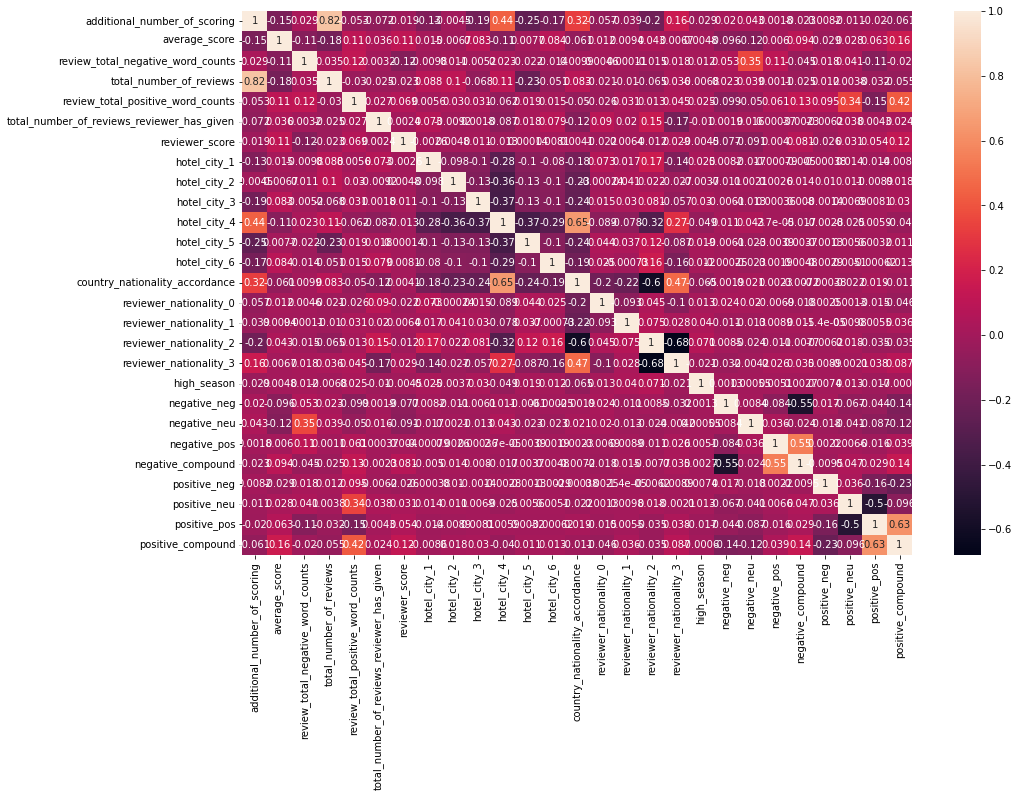

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   hotel_city_1                                515738 non-null  int64  
 9   hotel_city_2                                515738 non-null  int64  
 

 # ОБУЧЕНИЕ МОДЕЛИ

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 27), (386803, 27), (386803, 26), (309442, 26), (77361, 26))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8778267503590153


0.8778267503590155

<AxesSubplot: >

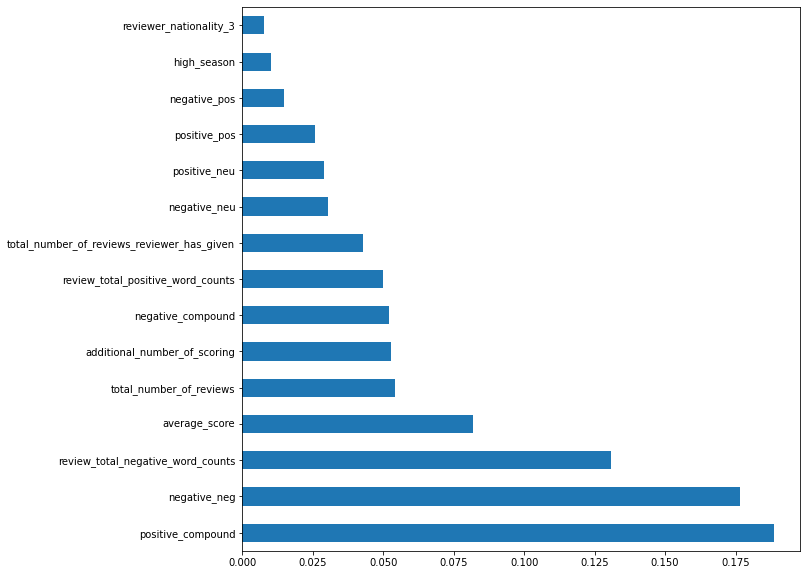

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_city_1,hotel_city_2,hotel_city_3,...,reviewer_nationality_3,high_season,negative_neg,negative_neu,negative_pos,negative_compound,positive_neg,positive_neu,positive_pos,positive_compound
56969,843,7.8,6,3801,0,1,0.0,0,0,0,...,1,0,0.000,1.000,0.000,0.0000,0.000,0.000,0.000,0.0000
20177,791,7.3,0,3609,12,11,0.0,0,0,0,...,1,0,0.000,0.000,0.000,0.0000,0.000,0.419,0.581,0.9022
108639,298,8.5,9,3550,20,29,0.0,1,0,0,...,1,1,0.333,0.667,0.000,-0.4588,0.000,0.630,0.370,0.8316
30390,843,7.8,15,3801,47,4,0.0,0,0,0,...,0,1,0.000,0.805,0.195,0.4404,0.000,0.708,0.292,0.9399
66439,248,9.2,0,945,40,1,0.0,0,0,0,...,1,1,0.000,0.000,0.000,0.0000,0.059,0.722,0.218,0.8063
37896,75,8.2,2,948,31,17,0.0,1,0,0,...,1,0,0.000,1.000,0.000,0.0000,0.000,0.504,0.496,0.9621
78782,54,8.7,35,1099,23,1,0.0,0,0,0,...,1,1,0.000,0.912,0.088,0.4380,0.000,0.719,0.281,0.8141
110407,106,9.0,7,855,7,13,0.0,0,0,0,...,1,0,0.362,0.638,0.000,-0.1779,0.000,0.311,0.689,0.7688
33601,904,8.1,6,16670,4,5,0.0,1,0,0,...,0,1,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000
30112,298,8.5,22,3550,31,45,0.0,1,0,0,...,0,0,0.086,0.811,0.104,0.1027,0.000,0.925,0.075,0.2732


In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

,reviewer_score,id
0,8.642,488440
1,7.646,274649
2,8.403,374688
3,9.729,404352
4,9.475,451596
...,...,...
128930,8.802,495812
128931,9.440,315577
128932,8.380,511968
128933,9.609,303386


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [ ]:
predict_submission

array([8.642, 7.646, 8.403, ..., 8.38 , 9.609, 7.53 ])

In [ ]:
list(sample_submission)

['reviewer_score', 'id']

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.642,488440
1,7.646,274649
2,8.403,374688
3,9.729,404352
4,9.475,451596
5,9.108,302161
6,7.490,317079
7,7.496,13963
8,8.112,159785
9,7.454,195089
